In [1]:
import sys
cwd = "/Users/jordydikkers/personal/projects/machi-koro-ai"
sys.path.append(cwd)
import os
os.chdir(cwd)

In [2]:
import pickle
import torch
from buffer import Buffer, BigBuffer
import matplotlib.pyplot as plt
from env_vector_state import GymMachiKoro
from mcts_agent import MCTSAgent
import torch.nn as nn
import gym
import numpy as np
import itertools


In [3]:
class MultiDimensionalOneHot:
    def __init__(self, values):
        # np array where each row is padded with nans
        self.values = torch.tensor(list(itertools.zip_longest(*values, fillvalue=np.nan))).T

        # the one_hot_start_indices represent the indices in a flattened array. Each index is the
        # start index of a onehot dimension.
        values_lengths = torch.sum(~torch.isnan( self.values), axis=1)
        self.one_hot_start_indices = values_lengths.cumsum(0) - values_lengths
        
        # the lenght of the flattened onehot array
        self.one_hot_len = sum(map(len, values))
        # self.start_indices = (np.cumsum(n_elements) - n_elements)

    def to_onehot(self, array):
        # one hot initialized by zeros
        one_hot = torch.zeros((len(array), self.one_hot_len))

        # The following line figures out what indices in the flattened onehot array need to be 
        # marked as `1`. It does that by taking the array and figure out the indices at which it
        # equals the self.values array. This results 3 array but only the last one is interesting,
        # therefore [-1] is used. This one is flattened for each row in `array` however, so it is
        # reshaped to (len(array), len(self.values)). Now only the indices for each row in 
        # self.values are known, so the one_hot_start_indices are added to find the indices in the
        # flattened one_hot.
        try:
            onehot_indices = torch.where(self.values == array[:,:,None])[-1].reshape(len(array), len(self.values)) + self.one_hot_start_indices
        except:
            # [print(row) for row in torch.cat((self.values, array.T), axis=1)]
            breakpoint()
        
        one_hot[torch.arange(len(array))[:, None], onehot_indices] = 1
        return one_hot


class PVNet(nn.Module):
    def __init__(
            self,
            observation_space: gym.Space,
            action_space: gym.Space,
            info: dict,
    ):
        super().__init__()
        self.observation_space = observation_space
        self.action_space = action_space
        self._info = info
        self._landmark_indices_in_action = [self._info["action_str_to_idx"][landmark] for landmark in self._info["landmarks"]]
        # num_inputs = gym.spaces.flatten_space(observation_space).shape[0]

        one_hot_indices = []
        one_hot_values = []
        identity_indices = []
        for player in info["observation_indices"]["player_info"].keys():
            for card in info["observation_indices"]["player_info"][player]["cards"].keys():
                card_index = info["observation_indices"]["player_info"][player]["cards"][card]
                card_values = info["observation_values"]["player_info"][player]["cards"][card]
                one_hot_indices.append(card_index)
                one_hot_values.append(card_values)

            identity_indices.append(info["observation_indices"]["player_info"][player]["coins"])
            identity_indices.append(info["observation_indices"]["player_info"][player]["tech_startup_investment"])

        for alley in info["observation_indices"]["marketplace"].keys():
            for pos in info["observation_indices"]["marketplace"][alley].keys():
                card_index = info["observation_indices"]["marketplace"][alley][pos]["card"]
                card_values = info["observation_values"]["marketplace"][alley][pos]["card"]
                one_hot_indices.append(card_index)
                one_hot_values.append(card_values)

                count_index = info["observation_indices"]["marketplace"][alley][pos]["count"]
                count_values = info["observation_values"]["marketplace"][alley][pos]["count"]
                one_hot_indices.append(count_index)
                one_hot_values.append(count_values)

        one_hot_indices.append(info["observation_indices"]["current_player_index"])
        one_hot_values.append(info["observation_values"]["current_player_index"])
        one_hot_indices.append(info["observation_indices"]["current_stage_index"])
        one_hot_values.append(info["observation_values"]["current_stage_index"])

        self._one_hot_indices = list(one_hot_indices)
        self._identity_indices = list(identity_indices)
        self._mdoh = MultiDimensionalOneHot(one_hot_values)

        num_inputs = self._mdoh.one_hot_len + len(self._identity_indices)
        num_outputs = action_space.n

        # self.fc1 = nn.Linear(num_inputs, 128)
        # self.fc2 = nn.Linear(128, 128)
        # self.fc3 = nn.Linear(128, num_outputs)

        # self.fc4 = nn.Linear(128, 64)
        # self.fc5 = nn.Linear(64, 1)
        self.fctrunk = nn.Linear(num_inputs, 64)
        self.fchidden1 = nn.Linear(64, 64)
        self.fclogits = nn.Linear(64, num_outputs)
        self.fcvalue = nn.Linear(64, 1)


        self.is_trained = False
        
        self.is_trained = False
        self.KLDiv = torch.nn.KLDivLoss(reduction="batchmean")
    def forward(self, x):
        x = torch.cat((self._mdoh.to_onehot(x[:, self._one_hot_indices]), x[:, self._identity_indices]), axis=1)
        # x = torch.relu(self.fc1(x))
        
        # x = torch.relu(self.fc2(x))
        # policy = self.fc3(x)
        # x = torch.relu(self.fc4(x))
        # value = torch.tanh(self.fc5(x))
        # return policy, value
        trunk = torch.relu(self.fctrunk(x))
        trunk = torch.relu(self.fchidden1(trunk))
        logits = self.fclogits(trunk)
        value = torch.tanh(self.fcvalue(trunk))

        return logits, value

    def predict(self, observation):

        input = torch.tensor(observation).unsqueeze(0).to(torch.float32)
        policy_pred, value_pred = self.forward(input)

        current_stage = self._info["stage_order"][observation[self._info["observation_indices"]["current_stage_index"]]]
        if current_stage == "build":
            current_player = self._info["player_order"][observation[self._info["observation_indices"]["current_player_index"]]]
            landmark_indices = [self._info["observation_indices"]["player_info"][current_player]["cards"][landmark] for landmark in self._info["landmarks"]]
            cost_for_all_unowned_landmarks = np.sum(~observation[landmark_indices].astype(bool)*self._info["landmarks_cost"])
            player_coins = observation[self._info["observation_indices"]["player_info"][current_player]["coins"]]
            if player_coins >= cost_for_all_unowned_landmarks:
                policy_pred[:, self._landmark_indices_in_action] = 1e10

        policy_pred = torch.nn.functional.softmax(policy_pred, 1)

        return policy_pred.squeeze().detach().numpy(), value_pred.detach().numpy().item()

    def loss_fn(self, policy_preds, value_preds, policy_targets, value_targets):
            policy_loss = self.KLDiv(torch.nn.functional.log_softmax(policy_preds), torch.tensor(policy_targets).to(torch.float32))
            value_loss = torch.nn.functional.mse_loss(value_preds, torch.tensor(value_targets).to(torch.float32))
            return value_loss + policy_loss

    def train(self, train_buffer, val_buffer, batch_size, epochs):
        
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)
        

        for epoch in range(epochs):
            train_batches = train_buffer.get_random_batches(batch_size = batch_size)

            tot_train_loss = 0
            train_steps_since_last_val_step = 0
            for i, batch in enumerate(train_batches):
                train_steps_since_last_val_step += 1
                obss, actions, rewards, next_obss, dones, player_ids, action_masks, values, probs = batch
                
                # policy_preds, value_preds = self.forward(torch.tensor(obss).to(torch.float32))
                prob_preds, value_preds = self.forward(torch.tensor(obss).to(torch.float32))
                loss = self.loss_fn(
                    policy_preds=prob_preds,
                    value_preds=value_preds,
                    policy_targets=probs,
                    value_targets=values
                )
                tot_train_loss += loss
                if i % 100 == 0:
                    obss, actions, rewards, next_obss, dones, player_ids, action_masks, values, probs = val_buffer[:]
                    # policy_preds, value_preds = self.forward(torch.tensor(obss).to(torch.float32))
                    prob_preds, value_preds = self.forward(torch.tensor(obss).to(torch.float32))
                    avg_val_loss = self.loss_fn(
                        policy_preds=prob_preds,
                        value_preds=value_preds,
                        policy_targets=probs,
                        value_targets=values
                    )
                    avg_train_loss = tot_train_loss/train_steps_since_last_val_step
                    print(f"epoch: {epoch} | train_loss: {avg_train_loss} | val_loss: {avg_val_loss}")
                    tot_train_loss = 0
                    train_steps_since_last_val_step = 0
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

In [4]:
with open(f"checkpoints/1.pkl", "rb") as file:
    buffer = pickle.load(file)
buffer.size

10105

In [5]:
env = GymMachiKoro(n_players=2, card_info_path="card_info_quick_game.yaml")

# pvnet = torch.load("checkpoints/0.pt") # PVNet(env.observation_space, env.action_space)

/var/folders/4k/zq7y_vc10hz_rjss8lkyh9640000gn/T/ipykernel_43825/3612192138.py:138: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  policy_loss = self.KLDiv(torch.nn.functional.log_softmax(policy_preds), torch.tensor(policy_targets).to(torch.float32))


epoch: 0 | train_loss: 3.8666696548461914 | val_loss: 3.749774932861328
epoch: 0 | train_loss: 2.4355335235595703 | val_loss: 2.2227530479431152
epoch: 1 | train_loss: 2.307760238647461 | val_loss: 2.18363094329834
epoch: 1 | train_loss: 2.0442140102386475 | val_loss: 1.925442099571228
epoch: 2 | train_loss: 1.5348927974700928 | val_loss: 1.800511121749878
epoch: 2 | train_loss: 1.6027320623397827 | val_loss: 1.5584408044815063
epoch: 3 | train_loss: 1.569109559059143 | val_loss: 1.546729326248169
epoch: 3 | train_loss: 1.4964412450790405 | val_loss: 1.521746277809143
epoch: 4 | train_loss: 1.5052130222320557 | val_loss: 1.5037169456481934
epoch: 4 | train_loss: 1.4608433246612549 | val_loss: 1.476217269897461
epoch: 5 | train_loss: 1.3788156509399414 | val_loss: 1.4849607944488525
epoch: 5 | train_loss: 1.364975094795227 | val_loss: 1.4476940631866455
epoch: 6 | train_loss: 1.242754578590393 | val_loss: 1.4618992805480957
epoch: 6 | train_loss: 1.1323764324188232 | val_loss: 1.5270881

(array([1285.,  870.,  550.,  414.,  269.,  212.,  159.,  140.,  108.,
         122.,   78.,   72.,   62.,   59.,   61.,   41.,   37.,   39.,
          33.,   20.,   31.,   21.,   19.,   20.,   19.,   19.,   18.,
          12.,    8.,   14.,   10.,   10.,   15.,   12.,    6.,   11.,
           7.,   16.,   11.,    9.,    7.,   10.,    5.,    7.,    7.,
           5.,   11.,    5.,    9.,    7.,   10.,    3.,    6.,    5.,
           4.,    5.,    5.,    9.,    6.,    6.,    4.,    7.,    5.,
           5.,    7.,    8.,    5.,    6.,    6.,    3.,    9.,   13.,
           7.,    7.,    9.,    7.,   13.,    8.,    9.,   15.,   14.,
          11.,   16.,   15.,   22.,    9.,   26.,   20.,   29.,   28.,
          36.,   57.,   75.,   90.,  134.,  169.,  254.,  450.,  915.,
        2531.]),
 array([-9.99612987e-01, -9.79617357e-01, -9.59621727e-01, -9.39626038e-01,
        -9.19630408e-01, -8.99634778e-01, -8.79639149e-01, -8.59643459e-01,
        -8.39647830e-01, -8.19652200e-01, -7.99656

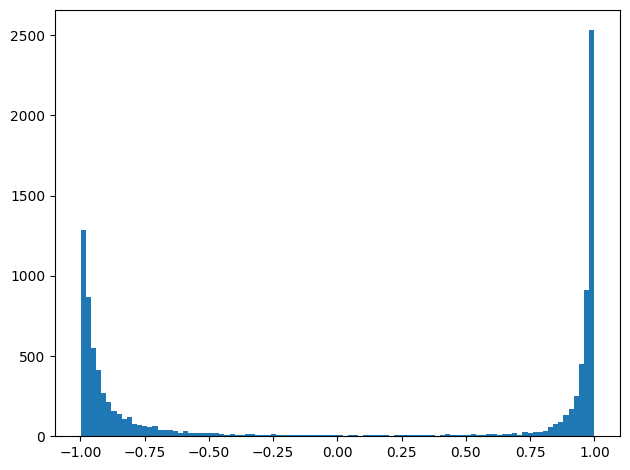

In [6]:
buffer.compute_values()
train_buffer, val_buffer = buffer.split_buffer_by_episode(0.2)
info = {
            "observation_indices": env.observation_indices,
            "observation_values": env.observation_values,
            "action_idx_to_str": env._action_idx_to_str,
            "action_str_to_idx": env._action_str_to_idx,
            "player_order": env.player_order,
            "stage_order": env._env._stage_order,
            "landmarks": env._env._landmark_cards_ascending_in_price,
            "landmarks_cost": [env.card_info[landmark]["cost"] for landmark in env._env._landmark_cards_ascending_in_price]
        }
pvnet = PVNet(env.observation_space, env.action_space, info)
pvnet.train(train_buffer=train_buffer, val_buffer=val_buffer, batch_size=64, epochs=20)

prob_preds, value_preds = pvnet.forward(torch.tensor(buffer.obss).to(torch.float32))

fig, axs = plt.subplots(1, 1, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs.hist(value_preds.detach().numpy().squeeze(), bins=100)

In [17]:
obss1, actions1, rewards1, next_obss1, dones1, player_ids1, action_masks1, values1, probs1 = buffer.get_episode(0)
obss2, actions2, rewards2, next_obss2, dones2, player_ids2, action_masks2, values2, probs2 = buffer.get_episode(1)

In [20]:
obss1[0] - obss2[0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,  -4.,   0.,   0.,   4.,   0.,   0.,
         0.,  -8.,   0.,   8.,   0.,   0.,   0.,  -9.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0., -11.,  11.,   0.,   0., -16.,
         0.,   0.,   0.,   0.,  17.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  -5.,   5.,
         0.,   6.,   0.,  -6.,   0.,   0.,   0.,   0.,   0.,  -7.,   0.,
         0., -12.,   0.,   0.,  12.,   0.,   0.,   

winning player: [0.]


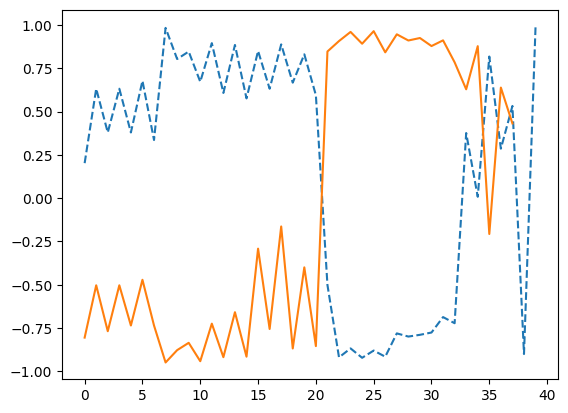

In [12]:
obss, actions, rewards, next_obss, dones, player_ids, action_masks, values, probs = val_buffer.get_episode(2)
prob_preds, value_preds = pvnet.forward(torch.tensor(obss).to(torch.float32))
p0_indices, _ = np.where(player_ids == 0)
p1_indices, _  = np.where(player_ids == 1)
print(f"winning player: {player_ids[-1]}")
plt.plot(np.arange(len(p0_indices)), value_preds[p0_indices].detach().numpy(), "--")
plt.plot(np.arange(len(p1_indices)), value_preds[p1_indices].detach().numpy(), "-")
plt.show()

In [27]:
val_buffer._episode_starts, val_buffer._episode_ends, train_buffer._episode_starts, train_buffer._episode_ends

({0: 0,
  1: 60,
  2: 112,
  3: 200,
  4: 270,
  5: 382,
  6: 474,
  7: 538,
  8: 604,
  9: 682,
  10: 732,
  11: 768,
  12: 812,
  13: 870,
  14: 926,
  15: 998,
  16: 1068,
  17: 1162,
  18: 1212,
  19: 1278,
  20: 1330,
  21: 1408,
  22: 1476,
  23: 1526,
  24: 1592,
  25: 1686,
  26: 1770,
  27: 1866},
 {0: 59,
  1: 51,
  2: 87,
  3: 69,
  4: 111,
  5: 91,
  6: 63,
  7: 65,
  8: 77,
  9: 49,
  10: 35,
  11: 43,
  12: 57,
  13: 55,
  14: 71,
  15: 69,
  16: 93,
  17: 49,
  18: 65,
  19: 51,
  20: 77,
  21: 67,
  22: 49,
  23: 65,
  24: 93,
  25: 83,
  26: 95,
  27: 87},
 {0: 0,
  1: 74,
  2: 164,
  3: 226,
  4: 328,
  5: 390,
  6: 452,
  7: 524,
  8: 606,
  9: 666,
  10: 728,
  11: 812,
  12: 890,
  13: 956,
  14: 1026,
  15: 1084,
  16: 1132,
  17: 1192,
  18: 1266,
  19: 1370,
  20: 1438,
  21: 1504,
  22: 1570,
  23: 1684,
  24: 1770,
  25: 1834,
  26: 1910,
  27: 2048,
  28: 2114,
  29: 2196,
  30: 2254,
  31: 2324,
  32: 2410,
  33: 2496,
  34: 2566,
  35: 2624,
  36: 2722,
  3

In [28]:
p0_indices, p1_indices

(array([ 0,  1,  7,  9, 10, 11, 12, 19, 22, 24, 29, 32, 33, 34, 35, 37, 39,
        47, 48, 49, 50, 51, 53, 56, 57]),
 array([ 2,  3,  4,  5,  6,  8, 13, 14, 15, 16, 17, 18, 20, 21, 23, 25, 26,
        27, 28, 30, 31, 36, 38, 40, 41, 42, 43, 44, 45, 46, 52, 54, 55]))